# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

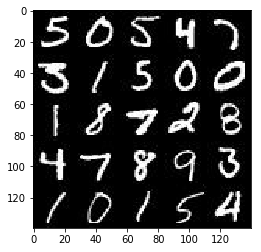

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

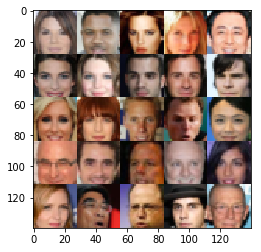

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32) 
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Uses architecture resembling that of the DCGAN excercise
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 28x28x1 or 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        # using batch norm on all layers except first and output
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #4x4x256 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        #now flatten
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))

        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # again, follow basic architecture from DCGAN excercise
        # start with input layer 3x3x512 so we end up with target size of 28x28x3
        h1 = tf.layers.dense(z, 3*3*512)
        # reshape for conv stack
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        # now change padding to valid to get to 14x14 instead of 12x12
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # 14x14x128
        
        # Output layer, now change kernel size to 5 to achieve target size of 28x28
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        # 28x28x3
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # this is mostly the same as in the  DCGAN exercise 
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_fake + d_loss_real
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25        
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                # double inputs for each layer
                batch_images *= 2.0
                # get random noise as input for generator
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                # run optimizer for discriminator 
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: batch_z, lr: learning_rate})
                # run optimizer for generator 
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr: learning_rate})
                
                # Check if is it time to print the Loss or just keep going (skip the print)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}... Batch Number {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                # Display generator results
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch Number 10... Discriminator Loss: 0.4582... Generator Loss: 12.4412
Epoch 1/1... Batch Number 20... Discriminator Loss: 0.5275... Generator Loss: 14.7405
Epoch 1/1... Batch Number 30... Discriminator Loss: 0.2812... Generator Loss: 3.9268
Epoch 1/1... Batch Number 40... Discriminator Loss: 0.0628... Generator Loss: 4.2923
Epoch 1/1... Batch Number 50... Discriminator Loss: 2.2467... Generator Loss: 13.2836
Epoch 1/1... Batch Number 60... Discriminator Loss: 1.0405... Generator Loss: 3.7095
Epoch 1/1... Batch Number 70... Discriminator Loss: 0.4887... Generator Loss: 1.5327
Epoch 1/1... Batch Number 80... Discriminator Loss: 1.2556... Generator Loss: 0.5394
Epoch 1/1... Batch Number 90... Discriminator Loss: 0.8256... Generator Loss: 1.1173
Epoch 1/1... Batch Number 100... Discriminator Loss: 0.6609... Generator Loss: 1.5584


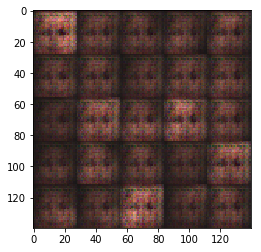

Epoch 1/1... Batch Number 110... Discriminator Loss: 0.4685... Generator Loss: 2.0356
Epoch 1/1... Batch Number 120... Discriminator Loss: 0.9084... Generator Loss: 1.2424
Epoch 1/1... Batch Number 130... Discriminator Loss: 0.3207... Generator Loss: 2.7454
Epoch 1/1... Batch Number 140... Discriminator Loss: 1.1032... Generator Loss: 2.5837
Epoch 1/1... Batch Number 150... Discriminator Loss: 0.5801... Generator Loss: 2.5412
Epoch 1/1... Batch Number 160... Discriminator Loss: 0.6255... Generator Loss: 1.0263
Epoch 1/1... Batch Number 170... Discriminator Loss: 1.3285... Generator Loss: 0.4578
Epoch 1/1... Batch Number 180... Discriminator Loss: 0.3350... Generator Loss: 3.6764
Epoch 1/1... Batch Number 190... Discriminator Loss: 0.5478... Generator Loss: 1.3845
Epoch 1/1... Batch Number 200... Discriminator Loss: 0.8380... Generator Loss: 1.0559


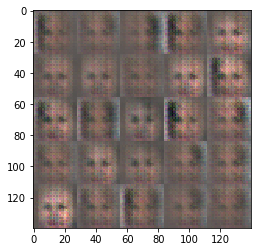

Epoch 1/1... Batch Number 210... Discriminator Loss: 1.2623... Generator Loss: 0.4563
Epoch 1/1... Batch Number 220... Discriminator Loss: 2.3242... Generator Loss: 3.8058
Epoch 1/1... Batch Number 230... Discriminator Loss: 0.7390... Generator Loss: 1.0382
Epoch 1/1... Batch Number 240... Discriminator Loss: 0.9896... Generator Loss: 0.7206
Epoch 1/1... Batch Number 250... Discriminator Loss: 0.7490... Generator Loss: 1.6246
Epoch 1/1... Batch Number 260... Discriminator Loss: 0.9407... Generator Loss: 0.6626
Epoch 1/1... Batch Number 270... Discriminator Loss: 0.7039... Generator Loss: 1.6347
Epoch 1/1... Batch Number 280... Discriminator Loss: 0.2989... Generator Loss: 2.9161
Epoch 1/1... Batch Number 290... Discriminator Loss: 0.5079... Generator Loss: 1.4141
Epoch 1/1... Batch Number 300... Discriminator Loss: 0.2482... Generator Loss: 3.1163


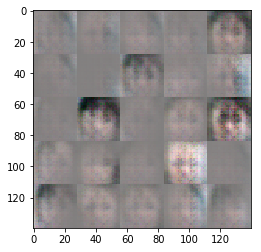

Epoch 1/1... Batch Number 310... Discriminator Loss: 0.6179... Generator Loss: 1.1266
Epoch 1/1... Batch Number 320... Discriminator Loss: 0.4877... Generator Loss: 2.6322
Epoch 1/1... Batch Number 330... Discriminator Loss: 0.8446... Generator Loss: 0.9650
Epoch 1/1... Batch Number 340... Discriminator Loss: 0.4181... Generator Loss: 5.1095
Epoch 1/1... Batch Number 350... Discriminator Loss: 0.2409... Generator Loss: 3.7765
Epoch 1/1... Batch Number 360... Discriminator Loss: 1.0628... Generator Loss: 1.0690
Epoch 1/1... Batch Number 370... Discriminator Loss: 0.9285... Generator Loss: 1.1869
Epoch 1/1... Batch Number 380... Discriminator Loss: 0.9877... Generator Loss: 0.9816
Epoch 1/1... Batch Number 390... Discriminator Loss: 0.8864... Generator Loss: 0.9439
Epoch 1/1... Batch Number 400... Discriminator Loss: 0.5827... Generator Loss: 1.4434


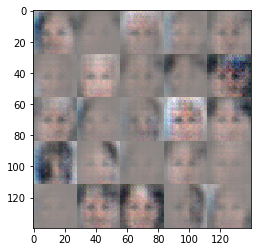

Epoch 1/1... Batch Number 410... Discriminator Loss: 0.4978... Generator Loss: 2.6606
Epoch 1/1... Batch Number 420... Discriminator Loss: 0.6468... Generator Loss: 1.0518
Epoch 1/1... Batch Number 430... Discriminator Loss: 0.3603... Generator Loss: 4.3546
Epoch 1/1... Batch Number 440... Discriminator Loss: 0.6096... Generator Loss: 1.2413
Epoch 1/1... Batch Number 450... Discriminator Loss: 0.5064... Generator Loss: 2.4832
Epoch 1/1... Batch Number 460... Discriminator Loss: 0.6511... Generator Loss: 1.4893
Epoch 1/1... Batch Number 470... Discriminator Loss: 0.2895... Generator Loss: 2.3688
Epoch 1/1... Batch Number 480... Discriminator Loss: 0.5555... Generator Loss: 1.5172
Epoch 1/1... Batch Number 490... Discriminator Loss: 1.2820... Generator Loss: 5.8622
Epoch 1/1... Batch Number 500... Discriminator Loss: 0.9432... Generator Loss: 0.9847


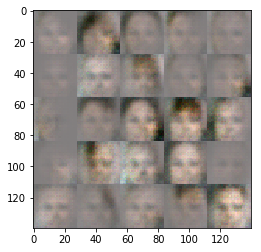

Epoch 1/1... Batch Number 510... Discriminator Loss: 0.1078... Generator Loss: 3.4650
Epoch 1/1... Batch Number 520... Discriminator Loss: 0.4657... Generator Loss: 1.4165
Epoch 1/1... Batch Number 530... Discriminator Loss: 0.9274... Generator Loss: 5.5579
Epoch 1/1... Batch Number 540... Discriminator Loss: 0.3939... Generator Loss: 2.1510
Epoch 1/1... Batch Number 550... Discriminator Loss: 0.2912... Generator Loss: 2.9441
Epoch 1/1... Batch Number 560... Discriminator Loss: 1.0855... Generator Loss: 0.8313
Epoch 1/1... Batch Number 570... Discriminator Loss: 0.3226... Generator Loss: 1.8164
Epoch 1/1... Batch Number 580... Discriminator Loss: 0.8168... Generator Loss: 2.2640
Epoch 1/1... Batch Number 590... Discriminator Loss: 0.4457... Generator Loss: 2.6634
Epoch 1/1... Batch Number 600... Discriminator Loss: 0.6980... Generator Loss: 1.9991


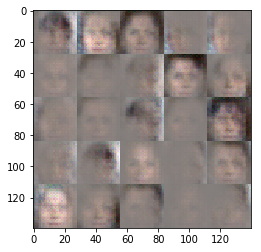

Epoch 1/1... Batch Number 610... Discriminator Loss: 0.6314... Generator Loss: 1.2991
Epoch 1/1... Batch Number 620... Discriminator Loss: 0.8630... Generator Loss: 2.0823
Epoch 1/1... Batch Number 630... Discriminator Loss: 0.4192... Generator Loss: 2.8366
Epoch 1/1... Batch Number 640... Discriminator Loss: 0.7196... Generator Loss: 1.2033
Epoch 1/1... Batch Number 650... Discriminator Loss: 0.7250... Generator Loss: 1.3911
Epoch 1/1... Batch Number 660... Discriminator Loss: 0.6697... Generator Loss: 1.3844
Epoch 1/1... Batch Number 670... Discriminator Loss: 0.7389... Generator Loss: 1.6145
Epoch 1/1... Batch Number 680... Discriminator Loss: 0.4647... Generator Loss: 1.3894
Epoch 1/1... Batch Number 690... Discriminator Loss: 0.7252... Generator Loss: 1.0142
Epoch 1/1... Batch Number 700... Discriminator Loss: 0.7633... Generator Loss: 1.2907


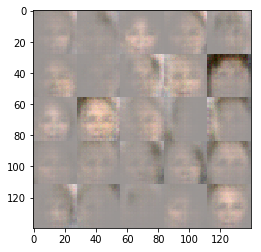

Epoch 1/1... Batch Number 710... Discriminator Loss: 0.1064... Generator Loss: 3.5826
Epoch 1/1... Batch Number 720... Discriminator Loss: 0.8577... Generator Loss: 1.3355
Epoch 1/1... Batch Number 730... Discriminator Loss: 0.3925... Generator Loss: 2.7723
Epoch 1/1... Batch Number 740... Discriminator Loss: 0.5302... Generator Loss: 1.8356
Epoch 1/1... Batch Number 750... Discriminator Loss: 0.3642... Generator Loss: 1.8209
Epoch 1/1... Batch Number 760... Discriminator Loss: 0.8325... Generator Loss: 2.8116
Epoch 1/1... Batch Number 770... Discriminator Loss: 0.8613... Generator Loss: 1.0411
Epoch 1/1... Batch Number 780... Discriminator Loss: 0.6370... Generator Loss: 1.4844
Epoch 1/1... Batch Number 790... Discriminator Loss: 1.4944... Generator Loss: 0.4543
Epoch 1/1... Batch Number 800... Discriminator Loss: 0.9873... Generator Loss: 0.6401


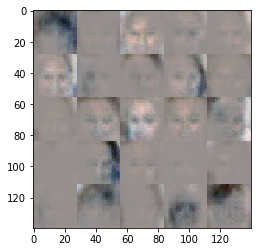

Epoch 1/1... Batch Number 810... Discriminator Loss: 0.5404... Generator Loss: 1.5589
Epoch 1/1... Batch Number 820... Discriminator Loss: 1.4346... Generator Loss: 3.3170
Epoch 1/1... Batch Number 830... Discriminator Loss: 0.7052... Generator Loss: 1.3211
Epoch 1/1... Batch Number 840... Discriminator Loss: 0.1171... Generator Loss: 3.9574
Epoch 1/1... Batch Number 850... Discriminator Loss: 0.3106... Generator Loss: 3.9217
Epoch 1/1... Batch Number 860... Discriminator Loss: 0.6478... Generator Loss: 1.3813
Epoch 1/1... Batch Number 870... Discriminator Loss: 0.8472... Generator Loss: 0.9993
Epoch 1/1... Batch Number 880... Discriminator Loss: 0.7653... Generator Loss: 2.0406
Epoch 1/1... Batch Number 890... Discriminator Loss: 0.8152... Generator Loss: 1.0012
Epoch 1/1... Batch Number 900... Discriminator Loss: 1.8613... Generator Loss: 0.2624


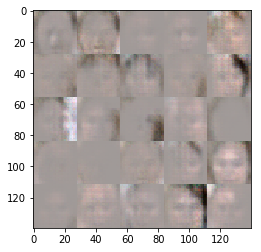

Epoch 1/1... Batch Number 910... Discriminator Loss: 0.6970... Generator Loss: 1.2696
Epoch 1/1... Batch Number 920... Discriminator Loss: 0.6398... Generator Loss: 1.0042
Epoch 1/1... Batch Number 930... Discriminator Loss: 0.4978... Generator Loss: 1.6688
Epoch 1/1... Batch Number 940... Discriminator Loss: 0.3702... Generator Loss: 2.2620
Epoch 1/1... Batch Number 950... Discriminator Loss: 0.5161... Generator Loss: 1.8436
Epoch 1/1... Batch Number 960... Discriminator Loss: 2.0085... Generator Loss: 0.2685
Epoch 1/1... Batch Number 970... Discriminator Loss: 1.0205... Generator Loss: 0.8446
Epoch 1/1... Batch Number 980... Discriminator Loss: 0.8616... Generator Loss: 1.0953
Epoch 1/1... Batch Number 990... Discriminator Loss: 0.7753... Generator Loss: 1.3713
Epoch 1/1... Batch Number 1000... Discriminator Loss: 0.7783... Generator Loss: 1.4640


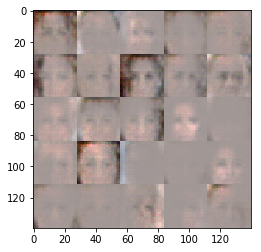

Epoch 1/1... Batch Number 1010... Discriminator Loss: 1.0973... Generator Loss: 0.6158
Epoch 1/1... Batch Number 1020... Discriminator Loss: 0.6306... Generator Loss: 1.2018
Epoch 1/1... Batch Number 1030... Discriminator Loss: 0.7696... Generator Loss: 3.6414
Epoch 1/1... Batch Number 1040... Discriminator Loss: 0.8292... Generator Loss: 1.3292
Epoch 1/1... Batch Number 1050... Discriminator Loss: 0.8322... Generator Loss: 1.0009
Epoch 1/1... Batch Number 1060... Discriminator Loss: 0.5273... Generator Loss: 1.8474
Epoch 1/1... Batch Number 1070... Discriminator Loss: 0.8108... Generator Loss: 2.3626
Epoch 1/1... Batch Number 1080... Discriminator Loss: 0.7639... Generator Loss: 1.2906
Epoch 1/1... Batch Number 1090... Discriminator Loss: 0.6167... Generator Loss: 1.3723
Epoch 1/1... Batch Number 1100... Discriminator Loss: 0.6524... Generator Loss: 1.1272


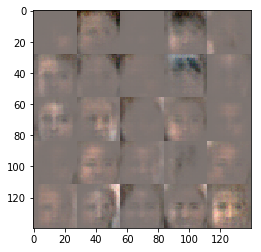

Epoch 1/1... Batch Number 1110... Discriminator Loss: 0.9773... Generator Loss: 2.3507
Epoch 1/1... Batch Number 1120... Discriminator Loss: 0.9989... Generator Loss: 0.8456
Epoch 1/1... Batch Number 1130... Discriminator Loss: 1.0210... Generator Loss: 0.7039
Epoch 1/1... Batch Number 1140... Discriminator Loss: 0.6573... Generator Loss: 1.5665


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.